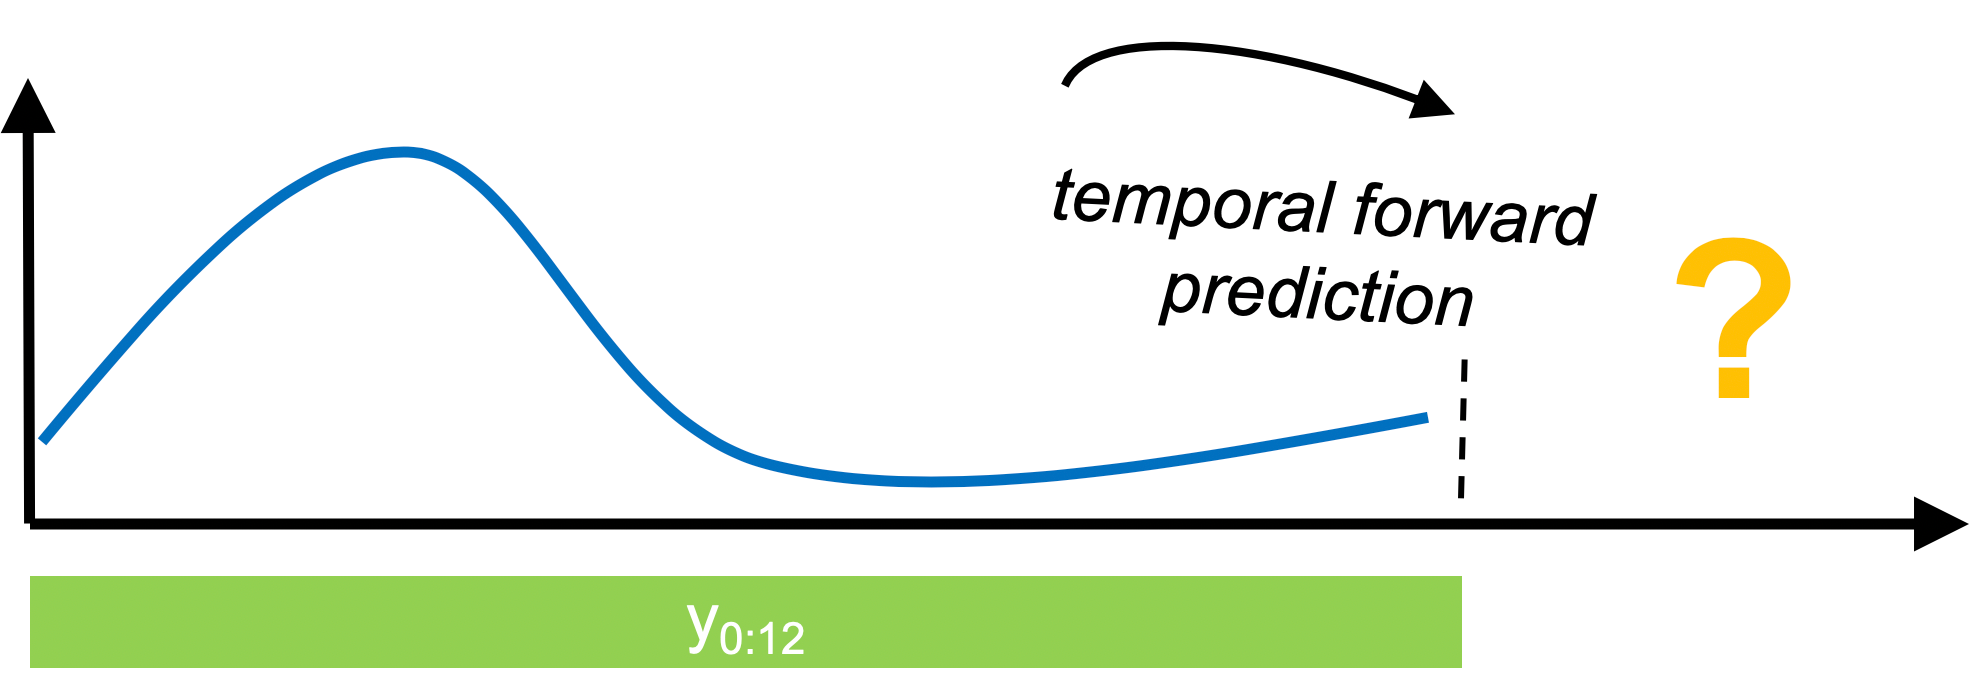

# Install packages.

This notebook uses [StatsForecast](https://github.com/Nixtla/statsforecast)!

You can install StatsForecast with:

```
pip install statsforecast
```

or

```
conda install -c conda-forge statsforecast
```

Vist our [Installation Guide](https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/installation.html) for further instructions.

In [1]:
conda install -c conda-forge statsforecast

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 24.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda




Solving environment: ...working... done

## Package Plan ##

  environment location: D:\anaconda3

  added / updated specs:
    - statsforecast


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    statsforecast-1.4.0        |     pyhd8ed1ab_0          78 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          78 KB

The following NEW packages will be INSTALLED:

  statsforecast      conda-forge/noarch::statsforecast-1.4.0-pyhd8ed1ab_0




statsforecast-1.4.0  | 78 KB     |            |   0% 
statsforecast-1.4.0  | 78 KB     | ##         |  21% 
statsforecast-1.4.0  | 78 KB     | ########## | 100% 
statsforecast-1.4.0  | 78 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Retrieving notices: ...working...

# Import Libraries

In [67]:
import numpy as np
import pandas as pd
import datetime
from statsforecast import StatsForecast

# Load Data

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/#:~:text=In%20the%20long%20format%2C%20each,below%20in%20the%20long%20format.) with three columns: `unique_id`, `ds` and `y`:
 - The `unique_id` (string, int or category) represents an identifier for the series.
 - The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
 - The `y` (numeric) represents the measurement we wish to forecast. The target column needs to be renamed to y if it has a different column name.

The cell below generates fake data for illustration, but you can read in data [from all sorts of places](https://www.theanalysisfactor.com/wide-and-long-data/#:~:text=In%20the%20long%20format%2C%20each,below%20in%20the%20long%20format.) using pandas. 

In [62]:
# Set the seed for reproducibility
np.random.seed(42)

# Function to generate random time series data
def generate_random_walk(start_value, num_steps, step_size, series_name):
    values = [start_value]
    for _ in range(1, num_steps):
        next_value = values[-1] + np.random.normal(loc=0, scale=step_size).cumsum().round()
        values.append(next_value)
    
    date_range = pd.date_range(start="2022-01-01", periods=num_steps, freq='W')
    time_series = pd.Series(values, index=date_range, name=series_name)
    return time_series

# Set start date and number of weeks
start_date = datetime.datetime(2022, 1, 1)
num_weeks = 104

# Generate time series data for three different series
series1 = generate_time_series(start_date, num_weeks, "Series1")
series2 = generate_time_series(start_date, num_weeks, "Series2")
series3 = generate_time_series(start_date, num_weeks, "Series3")

# Combine the series into a DataFrame
time_series_data = pd.DataFrame({'Series1': series1, 'Series2': series2, 'Series3': series3})

# Convert to long format for StatsForecast
df = time_series_data.reset_index().melt(id_vars='index', var_name='Series', value_name='Value')
df.columns = ['ds', 'unique_id', 'y']
df.head()

,ds,unique_id,y
0,2022-01-02,Series1,497.0
1,2022-01-09,Series1,138.0
2,2022-01-16,Series1,648.0
3,2022-01-23,Series1,1523.0
4,2022-01-30,Series1,234.0


In [63]:
df.tail()

,ds,unique_id,y
307,2023-11-26,Series3,592.0
308,2023-12-03,Series3,547.0
309,2023-12-10,Series3,202.0
310,2023-12-17,Series3,218.0
311,2023-12-24,Series3,1099.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         312 non-null    datetime64[ns]
 1   unique_id  312 non-null    object        
 2   y          312 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.4+ KB


In [65]:
#PLOT THE SERIES
StatsForecast.plot(df)

# Train multiple models for many series

StatsForecast can train many models on many time series efficiently.

Start by importing and instantiating the desired models. StatsForecast offers a wide variety of models grouped in the following categories:

 - Auto Forecast: Automatic forecasting tools search for the best parameters and select the best possible model for a series of time series. These tools are useful for large collections of univariate time series. Includes automatic versions of: Arima, ETS, Theta, CES.

 - Exponential Smoothing: Uses a weighted average of all past observations where the weights decrease exponentially into the past. Suitable for data with no clear trend or seasonality. Examples: SES, Holt’s Winters, SSO.

 - Benchmark models: classical models for establishing baselines. Examples: Mean, Naive, Random Walk

 - Intermittent or Sparse models: suited for series with very few non-zero observations. Examples: CROSTON, ADIDA, IMAPA

 - Multiple Seasonalities: suited for signals with more than one clear seasonality. Useful for low-frequency data like electricity and logs. Examples: MSTL.

 - Theta Models: fit two theta lines to a deseasonalized time series, using different techniques to obtain and combine the two theta lines to produce the final forecasts. Examples: Theta, DynamicTheta
 
Import and instantiate the models. Setting the `season_length` argument is sometimes tricky. This article on [Seasonal Periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by  the master, Rob Hyndmann, can be useful.

| Data      | Frequency |
|-----------|-----------|
| Annual    | 1         |
| Quarterly | 4         |
| Monthly   | 12        |
| Weekly    | 52        |

In [66]:
sl = 52 # season length for weekly data
ws = 13 # window size for window average method

In [86]:
# # CREATE A LIST OF MODELS AND STARTING PARAMETERS 
# models = [
#     HoltWinters(),
#     Croston(),
#     SeasonalNaive(season_length=24),
#     HistoricAverage(),
#     DOT(season_length=24)
# ]

# CREATE A LIST OF MODELS AND STARTING PARAMETERS 
models = [
    AutoARIMA(season_length=sl),
    AutoETS(season_length=sl),
    AutoCES(season_length=sl),
    AutoTheta(season_length=sl),
    Theta(),
    OptimizedTheta(),
    DynamicTheta(),
    DOT(season_length=sl, decomposition_type="multiplicative"),
    DOT(season_length=sl, decomposition_type="additive"),
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=sl),
    WindowAverage(window_size=ws),
    SeasonalWindowAverage(season_length=sl,window_size=ws),
    SimpleExponentialSmoothingOptimized,
    Holt(season_length=sl, error_type='A'),
    Holt(season_length=sl, error_type='M'),
    HoltWinters(season_length=sl, error_type='A'),
    HoltWinters(season_length=sl, error_type='M'),
    ADIDA(),
    Croston(),
    CrostonOptimized(),
    CrostonSBA(),
    IMAPA(),
    TSB(alpha_d=0.2, alpha_p=0.2),
    MSTL(season_length=sl)    
]

We fit the models by instantiating a new StatsForecast object with the following parameters:

 - `models`: a list of models. Select the models you want from models and import them.

 - `freq`: a string indicating the frequency of the data. (See pandas available frequencies.)

 - `n_jobs`: int, number of jobs used in the parallel processing, use -1 for all cores.

 - `fallback_model`: a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [87]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='W', 
    fallback_model = SeasonalNaive(season_length=52),
    n_jobs=-1,
)

# Forecast the Series

The forecast method takes two arguments: forecasts next h (horizon) and level.

 - `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead.

 - `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like ARIMA and Theta)

In [88]:
forecasts_df = sf.forecast(df=df, h=48, level=[90])
forecasts_df.T.head()

unique_id,Series2,Series2,Series2,Series2,Series2,Series2,Series2,Series2,Series2,Series2,...,Series3,Series3,Series3,Series3,Series3,Series3,Series3,Series3,Series3,Series3
ds,2023-12-31 00:00:00,2024-01-07 00:00:00,2024-01-14 00:00:00,2024-01-21 00:00:00,2024-01-28 00:00:00,2024-02-04 00:00:00,2024-02-11 00:00:00,2024-02-18 00:00:00,2024-02-25 00:00:00,2024-03-03 00:00:00,...,2024-09-22 00:00:00,2024-09-29 00:00:00,2024-10-06 00:00:00,2024-10-13 00:00:00,2024-10-20 00:00:00,2024-10-27 00:00:00,2024-11-03 00:00:00,2024-11-10 00:00:00,2024-11-17 00:00:00,2024-11-24 00:00:00
AutoARIMA,719.661,719.661,719.661,719.661,719.661,719.661,719.661,719.661,719.661,719.661,...,88.8636,84.6925,80.7169,76.9281,73.317,69.8755,66.5955,63.4695,60.4902,57.6508
AutoARIMA-lo-90,-203.494,-203.494,-203.494,-203.494,-203.494,-203.494,-203.495,-203.495,-203.495,-203.495,...,-1760.56,-1766.12,-1771.35,-1776.29,-1780.93,-1785.32,-1789.45,-1793.35,-1797.04,-1800.52
AutoARIMA-hi-90,1642.82,1642.82,1642.82,1642.82,1642.82,1642.82,1642.82,1642.82,1642.82,1642.82,...,1938.29,1935.5,1932.79,1930.14,1927.57,1925.07,1922.64,1920.29,1918.02,1915.82
AutoETS,677,612,1031,931,839,309,331,976,479,186,...,813,630,829,560,747,610,21,117,1278,592


Plot the results of 8 random series using the `StatsForecast.plot` method.

In [89]:
sf.plot(df,forecasts_df)

The `StatsForecast.plot` allows for further customization. For example, plot the results of the different models and unique ids.

In [92]:
# Plot to unique_ids and some selected models
sf.plot(df, forecasts_df, models=["MSTL","CES","IMAPA"], unique_ids=["Series1", "Series3"], level=[90])

# Evaluate the model’s performance
In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

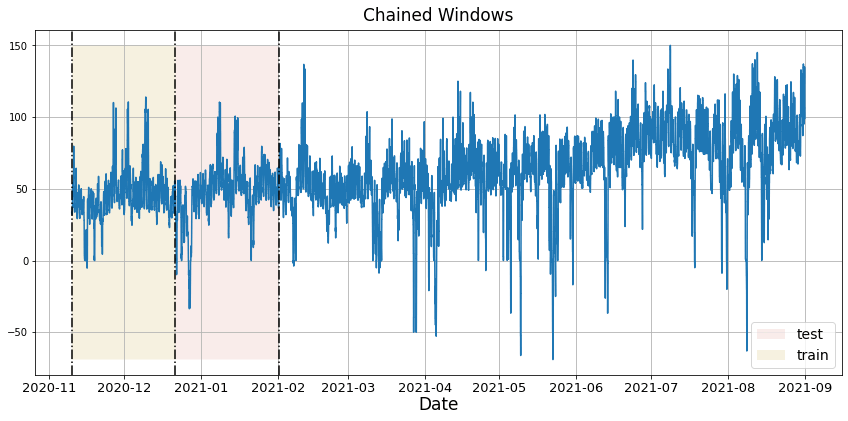

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 14 weeks (`n_windows=14`), forecasting every  month (step_size=4). Depending on your computer, this step should take around 1 min.


The `cross_validation` method from the `StatsForecast` class takes the following arguments.
 - `df`: training data frame
 - `h` (int): represents h steps into the future that are being forecasted. In this case, 24 hours ahead.
 - `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
 - `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [127]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=14,
    step_size=4,
    n_windows=10
)
crossvaldation_df.head()

,ds,cutoff,y,AutoARIMA,AutoETS,CES,AutoTheta,Theta,OptimizedTheta,DynamicTheta,...,<class 'statsforecast.models.SimpleExponentialSmoothingOptimized'>,Holt,HoltWinters,ADIDA,CrostonClassic,CrostonOptimized,CrostonSBA,IMAPA,TSB,MSTL
unique_id,,,,,,,,,,,,,,,,,,,,,
Series2,2023-01-15,2023-06-04,1031.0,388.648346,648.0,648.0,707.184265,707.332642,707.184265,707.332642,...,648.0,648.0,648.0,708.32428,708.32428,708.32428,672.908081,708.32428,676.203064,648.0
Series2,2023-01-08,2023-05-28,931.0,466.302216,1523.0,1523.0,706.900879,707.189453,706.900879,706.885437,...,1523.0,1523.0,1523.0,708.32428,708.32428,708.32428,672.908081,708.32428,676.203064,1523.0
Series2,2023-01-22,2023-06-11,839.0,498.745056,234.0,234.0,706.617493,707.046326,706.617493,706.437866,...,234.0,234.0,234.0,708.32428,708.32428,708.32428,672.908081,708.32428,676.203064,234.0
Series2,2023-01-08,2023-05-28,309.0,418.313507,234.0,234.0,706.334106,706.903198,706.334106,705.989990,...,234.0,234.0,234.0,708.32428,708.32428,708.32428,672.908081,708.32428,676.203064,234.0
Series2,2023-01-29,2023-06-18,331.0,383.035950,1579.0,1579.0,706.050720,706.760071,706.050720,705.541809,...,1579.0,1579.0,1579.0,708.32428,708.32428,708.32428,672.908081,708.32428,676.203064,1579.0


Next, we will evaluate the performance of every model for every series using common error metrics like Mean Absolute Error (MAE) or Mean Square Error (MSE) Define a utility function to evaluate different error metrics for the cross validation data frame.

First import the desired error metrics from `mlforecast.losses`. Then define a utility function that takes a cross-validation data frame as a metric and returns an evaluation data frame with the average of the error metric for every unique id and fitted model and all cutoffs.

In [113]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

In [114]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

> **Warning** <br> You can also use Mean Average Percentage Error (MAPE), however for granular forecasts, MAPE values are extremely hard to judge and not useful to assess forecasting quality.

Create the data frame with the results of the evaluation of your cross-validation data frame using a Mean Squared Error metric.

In [128]:
evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mse)
evaluation_df.head()

,AutoARIMA,AutoETS,CES,AutoTheta,Theta,OptimizedTheta,DynamicTheta,DynamicOptimizedTheta,HistoricAverage,Naive,...,Holt,HoltWinters,ADIDA,CrostonClassic,CrostonOptimized,CrostonSBA,IMAPA,TSB,MSTL,best_model
unique_id,,,,,,,,,,,,,,,,,,,,,
Series1,224518.175413,5.731883e+05,5.731883e+05,229982.205789,229990.138251,230875.090353,229933.019359,229141.385556,227867.751511,429345.306844,...,5.731883e+05,5.731883e+05,229342.462246,229136.562583,229342.462246,221412.463268,229342.462246,231156.300427,5.731883e+05,CrostonSBA
Series2,399537.218758,8.360424e+05,8.360424e+05,329672.926517,328970.708463,329028.795520,329019.157944,327446.093417,325357.286737,470486.181391,...,8.360424e+05,8.360424e+05,327441.955526,327441.955526,327441.955526,321852.449019,327441.955526,329186.807696,8.360424e+05,CrostonSBA
Series3,484871.588171,1.091332e+06,1.091332e+06,478866.295913,478739.364016,474418.842359,478847.475038,475545.626121,478561.963683,951278.659264,...,1.091332e+06,1.091332e+06,475414.200395,475414.200395,475414.200395,473526.101850,475414.200395,512798.368854,1.091332e+06,WindowAverage


Create a summary table with a model column and the number of series where that model performs best. In this case, the Arima and Seasonal Naive are the best models for 10 series and the Theta model should be used for two.

In [129]:
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

You can further explore your results by plotting the unique_ids where a specific model wins.

In [145]:
seasonal_ids = evaluation_df.query('best_model == "CrostonSBA"').index
sf.plot(df,forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","CrostonSBA","MSTL"])

# Select the best model for every unique series
Define a utility function that takes your forecast’s data frame with the predictions and the evaluation data frame and returns a data frame with the best possible forecast for every unique_id.

In [134]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

Create your production-ready data frame with the best forecast for every unique_id.

In [137]:
prod_forecasts_df = get_best_model_forecast(forecasts_df.reset_index(), evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model
0,Series1,2023-12-31,689.273865
1,Series1,2024-01-07,689.273865
2,Series1,2024-01-14,689.273865
3,Series1,2024-01-21,689.273865
4,Series1,2024-01-28,689.273865


Plot the results

In [139]:
sf.plot(df, prod_forecasts_df, level=[90])